In [12]:
#Importing libraries
import matplotlib as mpl

%config InlineBackend.figure_formats = ['svg']

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'mathtext.fontset': 'cm'})
mpl.rcParams.update({'axes.labelsize': 22})
mpl.rcParams.update({'axes.titlesize': 16})
mpl.rcParams.update({'axes.linewidth': 0.5})
mpl.rcParams.update({'xtick.labelsize': 10})
mpl.rcParams.update({'ytick.labelsize': 10})

import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np #Needed for a bunch of mathematical operations.

In [13]:
import xlrd #Documentation on how to use xlrd @ https://openpyxl.readthedocs.io/en/stable/
import numpy as np



#Extracting Data Experimental Data Excel File
workbook = xlrd.open_workbook('Practice_Data.xlsx')

#Setting up Model Parameters sheet
sheet_MP = workbook.sheet_by_name('MODEL PARAMETERS')

## Creating cell value range of the Maxwell Model Mode results
cell_range = sheet_MP.cell_value(2,3)
MaxModelModes = np.zeros((8,2))

for i in range(0,2):
    for j in range(0,8):
        
        JJ = sheet_MP.cell_value(j+2,i+4)
        JJ = float(JJ)
        MaxModelModes[j,i] = JJ
## MaxModelModes has lambdai and Gi in the first and second columns respectively. Lambda [=] sec, Gi [=] Pa
LambdA = MaxModelModes[:,0] # Array of the lambda values
GiRelax = MaxModelModes[:,1] # Array of the relaxtion modulus values
N = np.size(LambdA) # Number of modes of the maxwell model. This will be used below for integral calculation in the BKBZ model.

## Bring in other experimentally determined values
alpha = 2.5
beta = 25 #
theta = -0.15 # this is the ratio of the normal stress differences, this would have been found while doing another experiment.

#The KBKZ is a big numerical integration to get the shear stress values basically. So we need to integrate from -infinity to t while summing over all the modes on this inside. 

print(LambdA)
print(GiRelax)

[1.55845720e-06 4.25559234e-05 5.52955844e-04 5.82683685e-03
 5.57252859e-02 4.50360355e-01 3.64496726e+00 5.62537847e+01]
[7.44306209e+05 1.81334450e+05 1.24810328e+05 7.97724935e+04
 4.20035239e+04 1.52843839e+04 1.97676151e+03 9.57913877e+01]


## Defining the deformation tensors

In [14]:
# Defining the Cauchy and Finger Tensors here.

def Cauchy(G1, G2, strainType):
    #Defining the Cauchy strain tensor with strain at t1 =  gamma 1 and strain at t2 = gamma 2
    C = np.zeros((3,3))
    gamma1 = G1
    gamma2 = G2
    dif = gamma2 - gamma1
    if strainType == "Shear":
        C[0,0] = C[2,2] = 1
        C[0,1] = C[1,0] = dif
        C[1,1] = 1 + (dif)**2 
    elif strainType == 'Extension':
        C[0,0] = np.exp(2 * (dif))
        C[1,1] = C[2,2] = np.exp(-(dif))
    
    else :
        print('Remember to give a strain type')
    
    return C


def Finger(G1, G2, strainType):
    #Defining the Finger strain tensor with strain at t1 =  gamma 1 and strain at t2 = gamma 2
    B = np.zeros((3,3))
    gamma1 = G1
    gamma2 = G2
    dif = gamma1 - gamma2
    if strainType == "Shear":
        B[1,1] = B[2,2] = 1
        B[0,1] = dif 
        B[1,0] = dif
        B[0,0] = 1 + (dif)**2 
    elif strainType == 'Extension':
        B[0,0] = np.exp(2 * (dif))
        B[1,1] = B[2,2] = np.exp(-(dif))
    
    else :
        print('Remember to give a strain type')
    
    return B


# Getting the invariants of the strain tensors
def Invariants3by3(Tensor):
    # Takes any 3x3 matrix and calculates the invrariants of the matrix.
    # I will simply add the values as described in textbook. Rather than doing tedious calculations
    Inv1 = Tensor[0,0] + Tensor[1,1] + Tensor[2,2]
    Inv2 = Tensor[0,0]*Tensor[2,2] + Tensor[1,1]*Tensor[2,2] + Tensor[0,0]*Tensor[2,2] - Tensor[0,1]*Tensor[1,0] - Tensor[1,2]*Tensor[2,1] - Tensor[0,2]*Tensor[2,0]
    Inv3 = np.linalg.det(Tensor)
    return (Inv1,Inv2,Inv3)

## Defining the strain 


In [15]:
#For now we are only using start-up, so the gamma is easy to define

def gammaStartUpSS(gamma0,t):
    if t<0:
        return 0
    else:
        return (gamma0*t)

## Writing out the important functions for the integration


In [16]:
def RelaxationMod(t):
    RelSum = 0
    for i in range(0,N):
        RelSum += (GiRelax[i]) * np.exp(-(t) / LambdA[i]) # Becareful of the definition of tend here!
    return RelSum

def MemoryMod(s):
    MemSum = 0
    for i in range(0,N):
        MemSum += (GiRelax[i]/LambdA[i]) * np.exp(-(s) / LambdA[i]) # Becareful of the definition of tend here!
    return MemSum

def DampingFunction(t,gamma0,StrainType):
    ##Note beta and alpha are global variable used when the function is first called!
    
    #Bring in the finger tensor
    StrainTensor = Finger(gammaStartUpSS(gamma0,t),gammaStartUpSS(gamma0,0),StrainType)
    #Calculate the invariants
    Inv1,Inv2,Inv3 = Invariants3by3(StrainTensor)
    I = beta*Inv1 + (1-beta)*Inv2 #Using the Papanastasiou Invariant
    damping = alpha/(I + (alpha-3)) #Calculating the damping value 
    return (damping)
    #print(damping)

## Defining the integrated term and the front term from Eq. (X) of the report.


In [51]:
## Starting with the integrated term which is integrated from 0 to t for ds

def BKBZ_Int(s,gamma0,StrainType):
    #Get the memory modulus sum for the current value of s
    Term1 = MemoryMod(s)
    #Get the damping function
    Term2 = DampingFunction(s,gamma0,StrainType)
    # Getting the strain from the correct position in the deformation tensor.
    B = Finger(gammaStartUpSS(gamma0,s),gammaStartUpSS(gamma0,0),StrainType)
    if StrainType == 'Extension': #row in the stress tensor. Can be from 0 to 2
        row = 0
        col = 0
        Term3 = (B[row,col] - B[row+1,col+1])#*gamma0
    elif StrainType == 'Shear':
        row=1
        col =0
        Term3 = B[row,col]#*gamma0
    Fin = Term1*Term2*Term3
    return Fin

def BKBZ_Front(t,gamma0,StrainType):
    #Get the relaxation modulus sum for the current value of t
    Term1 = RelaxationMod(t)
    #Get the damping function
    Term2 = DampingFunction(t,gamma0,StrainType)
    # Getting the strain from the correct position in the deformation tensor.
    B = Finger(gammaStartUpSS(gamma0,t),gammaStartUpSS(gamma0,0),StrainType)
    if StrainType == 'Extension': #row in the stress tensor. Can be from 0 to 2
        row = 0
        col = 0
        Term3 = (B[row,col] - B[row+1,col+1])#*gamma0
    elif StrainType == 'Shear':
        row=1
        col =0
        Term3 = B[row,col]#*gamma0
    Fin = Term1*Term2*Term3
    return Fin



## Writting out a function that integrates BKBZ_Int using romberg integration

In [52]:
def Romber_BKBZ(t,gamma0,StrainType,tol = 1e-6,maxit = 10):
    tstart = 0
    # Initialize the Romberg Matrix
    I = np.zeros((maxit+1,maxit+1))
    # Initialization
    n = 1
    tarray = np.linspace(tstart,t)
    dt = (t - tstart) / n
    II = 0
    for i in range(0,n): #Simple trapz integration
        II += (BKBZ_Int(tarray[i],gamma0,StrainType) + BKBZ_Int(tarray[i+1],gamma0,StrainType))*dt/2
    I[0,0] = II
    iter = 0
    
    ## Loop until convergence or maxit is attained
    while ( iter < maxit ):
        iter += 1

        # Divide h by 2 at each iteration and get new time interval
        n = 2**iter
        tarray = np.linspace(tstart,t,n+1)    
        dt = (t - tstart) / n
        # Compute an approximation with trapezoidal rule with h = ( b - a ) / 2^iter
        II = 0
        for i in range(0,n):
             II+= (BKBZ_Int(tarray[i],gamma0,StrainType)+BKBZ_Int(tarray[i+1],gamma0,StrainType))*dt/2
        I[iter,0] = II
        # Compute the improved estimates at each level
        for k in range(1,iter+1):
            j = iter - k;
            I[j,k] = ( 4**k * I[j+1,k-1] - I[j,k-1] ) / ( 4**k - 1 )

            # Compute relative error and check convergence
        ea = np.abs( ( I[0,iter] - I[1,iter-1] ) / I[0,iter] )
        if ea < tol: break

        integral = I[0,iter]
        
        niter = iter
    return(integral)

## Now we can use what we have to calculate for the start up viscosity

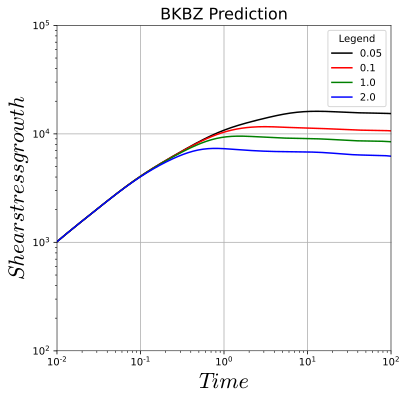

In [65]:
## Defining fitting parameters
alpha = 2.5
beta = 25

## Define StrainType and gamma0
StrainType = 'Shear'
gamma05 = 0.1
gamma01 = 0.5
gamma1 = 1
gamma2 = 2


## Creating the time interval
tt = np.logspace(-2,2,200)

#Initializing
Int1 = np.zeros(len(tt))
Int2 = np.zeros(len(tt))
Int3 = np.zeros(len(tt))
Int4 = np.zeros(len(tt))
for i in range(0,len(tt)):
    Int1[i] = (BKBZ_Front(tt[i],gamma05,StrainType) + Romber_BKBZ(tt[i],gamma05,StrainType,tol = 1e-10,maxit = 10))/gamma05
    Int2[i] = (BKBZ_Front(tt[i],gamma01,StrainType) + Romber_BKBZ(tt[i],gamma01,StrainType,tol = 1e-10,maxit = 10))/gamma01
    Int3[i] = (BKBZ_Front(tt[i],gamma1,StrainType) + Romber_BKBZ(tt[i],gamma1,StrainType,tol = 1e-10,maxit = 10))/gamma1
    Int4[i] = (BKBZ_Front(tt[i],gamma2,StrainType) + Romber_BKBZ(tt[i],gamma2,StrainType,tol = 1e-10,maxit = 10))/gamma2
    
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot( tt, Int1,  color='black', label='0.05' )
ax.plot( tt, Int2,  color='red', label='0.1' )
ax.plot( tt, Int3,  color='green', label='1.0' )
ax.plot( tt, Int4,  color='blue', label='2.0' )
ax.set_xlabel('$Time$')
ax.set_ylabel('$Shear stress growth$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([0.01, 100, 100, 1e5])
ax.set_title('BKBZ Prediction')
ax.legend(loc='best',title='Legend')
ax.grid()  